# Pipeline Img Processing

### Import Statements

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, data
from scipy import ndimage as ndi

In [114]:
from skimage.color import rgb2gray
from skimage.filters import sobel,threshold_otsu, threshold_yen, threshold_minimum, threshold_isodata, try_all_threshold

from skimage.filters.rank import median, equalize, mean_bilateral
from skimage import restoration
from skimage.morphology import disk
from skimage import exposure
from skimage import img_as_ubyte, img_as_float
from skimage import color, io, morphology, img_as_ubyte, feature, exposure, filters
import matplotlib.pyplot as plt
from skimage import io, img_as_ubyte
from skimage.exposure import equalize_hist, equalize_adapthist
import scipy.ndimage as ndi
import glob
from skimage.external import tifffile
from skimage.morphology import closing
from skimage.measure import label, regionprops
import matplotlib.patches as mpatches


#from pysrm import srm

## 1. Read image using virtual memory
- strategies to handle large volumes
- conserve_memory and take a pick a slice at a time

In [117]:
#path = "/Users/dani/Documents/data/fibers/newNatalie/globus/recon_20141209_235811_127_1_InSituPyro_curedRT_HC_7_enhcont/"
#path = "/Users/mirasilvia/SULI Spring 2019/Summer 2019/Natalie's Data/recon/recon_20141209_235811_127_1_InSituPyro_curedRT_HC_7_enhcont/"
path = "/global/cfs/cdirs/als/users/dushizima/Natalie/orig/"
#filename = "yourmultitif.tif"

import fnmatch,os
nfiles = len(fnmatch.filter(os.listdir(path),'*.tiff'))
# Check if multi-tiff
filename = path+"*.tiff"
#ic = io.ImageCollection(filename,conserve_memory=True) #never keeps more than 1 slice in mem
nslices = len(ic)
print("This folder contains: "+str(nfiles) + "files")
print("This file contains: "+str(nslices) + " slices")

This folder contains: 2160
This file contains: 2160 slices


### Visualizing a single slice

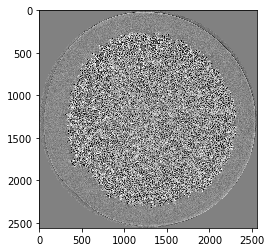

In [44]:
plt.imshow(ic[1000], cmap='gray')

### Dimensions of Stack

In [13]:
print('-----------------------------------------------------------------------')
print('Stack dim is',ic[0].shape,',',nfiles)
print('-----------------------------------------------------------------------')      

-----------------------------------------------------------------------
Stack dim is (2560, 2560) , 2160
-----------------------------------------------------------------------


## Auxiliary Functions

In [30]:
nslice_init = 159
nslice_end = 1158
ndown = 20
#input is an image collector: does not depend of other variables
def maxProjection(ic):
    IM_MAX = ic[0]
    for n in np.arange(nslice_init,nslice_end,ndown):
        IM_MAX = np.maximum(IM_MAX,ic[n+1])
    return IM_MAX    


In [18]:
def pltdani(before,after, lut):
    f, ax = plt.subplots(1, 2, figsize=(20, 20))
    ax[0].imshow(before,cmap=lut)
    ax[1].imshow(after,cmap=lut)

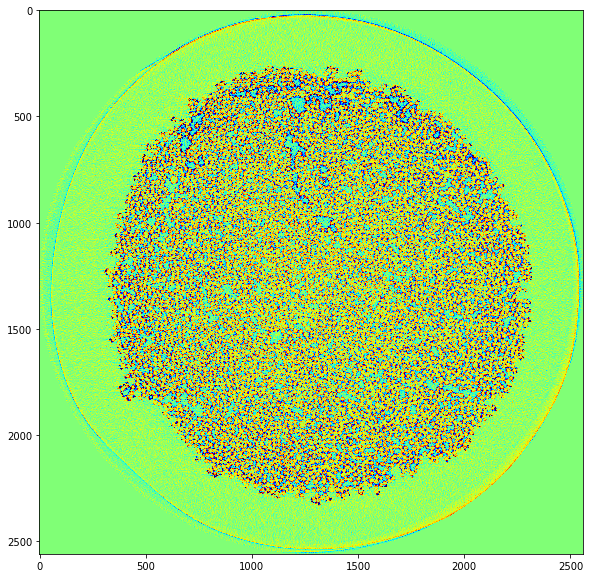

In [77]:
#SC here
focus = ic[1000]
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(focus,cmap='jet')

In [96]:

raw = ic[1000] #slice 1000
#import csv and check if the right thing
import pandas as pd
df = pd.read_csv('Results-slice1000-ds3.csv')
gt = np.zeros(focus.shape)
for i in np.arange(len(df)):
    y = int(df['X'][i])
    x = int(df['Y'][i])
    gt[x,y]=255
gt = morphology.dilation(gt,morphology.selem.disk(8))

In [100]:
gt = np.zeros(raw.shape)
for i in np.arange(len(df)):
    y = int(df['X'][i]) #switched in the csv file!!
    x = int(df['Y'][i])
    gt[x,y]=255
if len(df)==0:
    print("Error loading pts file")
else:
    gt = morphology.dilation(gt, morphology.selem.disk(8))

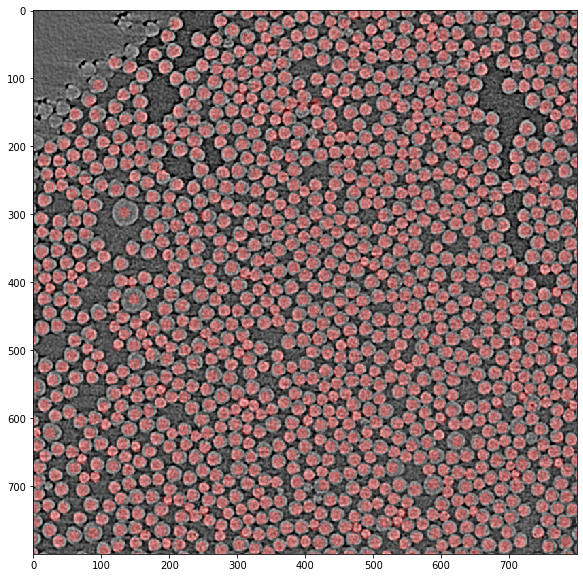

In [119]:
#pltdani(fake[500:1000,500:1000],focus[500:1000,500:1000],lut='gray')
from skimage.color import label2rgb
a = gt[500:1300,500:1300]
b = raw[500:1300,500:1300]
overlay =  label2rgb(a, image=b, bg_label=0)


f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(overlay)

In [105]:
#Creating a fake mask to prepare for Matt

n = 8 #level of distortion

gt2 = np.zeros(raw.shape)
for i in np.arange(len(df)):
    y = int(df['X'][i] + np.random.randint(-n,n)) #switched in the csv file!!
    x = int(df['Y'][i] + np.random.randint(-n,n))
    gt2[x,y]=255
if len(df)==0:
    print("Error loading pts file")
else:
    gt2 = morphology.dilation(gt2, morphology.selem.disk(8))

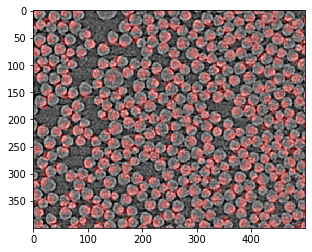

In [106]:
#pltdani(fake[500:1000,500:1000],focus[500:1000,500:1000],lut='gray')
from skimage.color import label2rgb
a = gt2[800:1200,500:1000]
b = raw[800:1200,500:1000]
overlay =  label2rgb(a, image=b, bg_label=0)
plt.imshow(overlay)

In [110]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score
def calc_metric(y_pred, y_true):
    cm = confusion_matrix(y_pred.ravel(),y_true.ravel())
    tn, fp, fn, tp = cm.ravel()
    dice = (2.0 * tp) / ((2.0 * tp) + fp + fn)
    jaccard = (1.0 * tp) / (tp + fp + fn)
    sensitivity = (1.0 * tp) / (tp + fn)
    specificity = (1.0 * tn) / (tn + fp)
    accuracy = (1.0 * (tn + tp)) / (tn + fp + tp + fn)
    auc = 1 - 0.5 * (((1.0 * fp) / (fp + tn)) + ((1.0 * fn) / (fn + tp)))
    prec = float(tp)/float(tp + fp)
    fscore = float(2*tp)/float(2*tp + fp + fn)
    #kappa = cohen_kappa_score(y_pred, y_true)
    return sensitivity, specificity, accuracy, auc, dice

In [113]:
print(calc_metric(gt,gt))

(1.0, 1.0, 1.0, 1.0, 1.0)


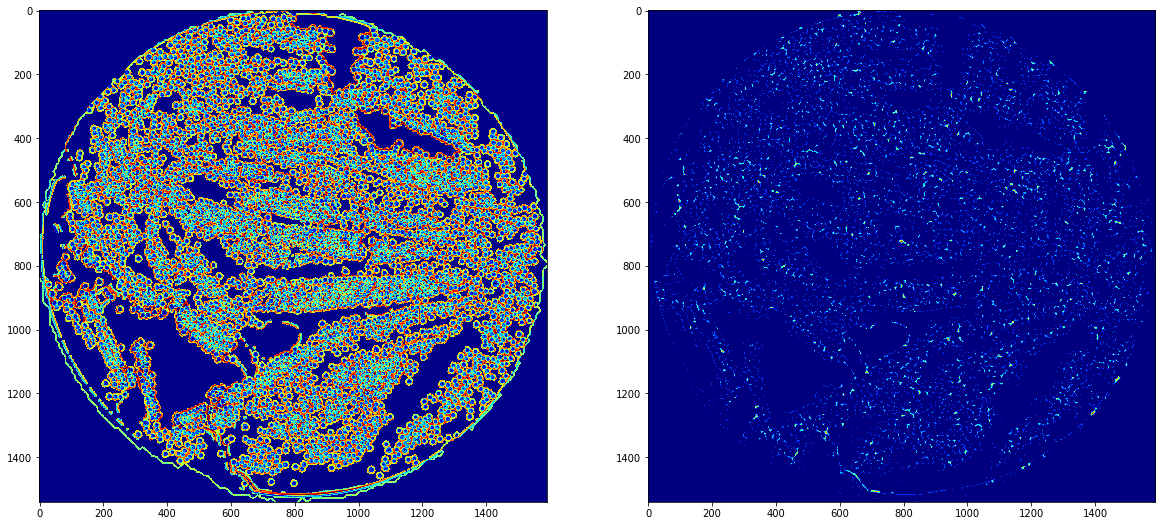

In [26]:
pltdani(img,m,'jet')

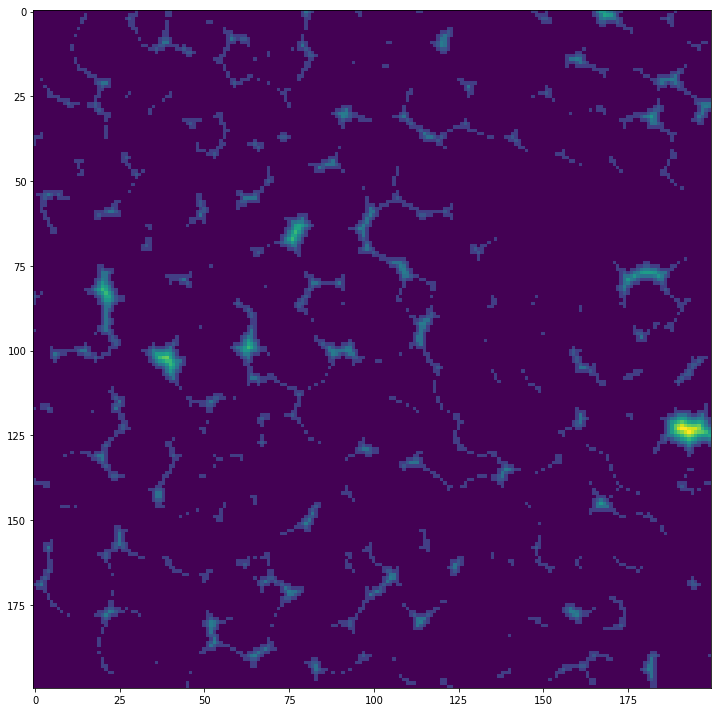

In [27]:
fig, axes = plt.subplots(1, 1, figsize=(15, 10))
axes.imshow(m[600:800,600:800])
plt.tight_layout()

# DoH, DoG, Laplace

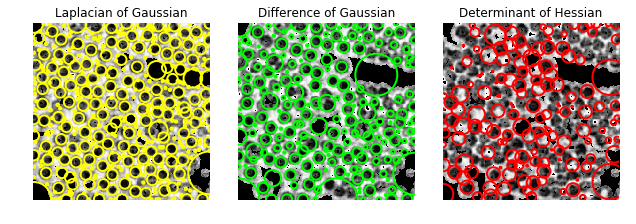

In [28]:
from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

import matplotlib.pyplot as plt


image = img[600:800,600:800]#data.hubble_deep_field()[0:500, 0:500]
image_gray = restoration.denoise_bilateral(image,multichannel=False)
image_gray = 255 - img_as_ubyte(image_gray)

blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=.1)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(image_gray, max_sigma=20, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(image_gray, max_sigma=20, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(image, interpolation='nearest',cmap='gray')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

# Hough Circle Transform

1. What would be a good radius approaximation? Maybe increase the range of a radius and the increase by +1 just to  try it out. 

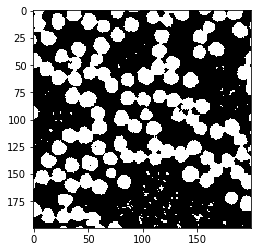

In [29]:
# masking smaller picture first
gray_thresh = threshold_isodata(ic[1000][600:800,600:800])
gray_im = ic[1000][600:800,600:800] > gray_thresh

# how does it look?
plt.imshow(gray_im, cmap='gray')

### Area Calculation

In [30]:
# crop even more to reduce pepper/noise
two = img_as_ubyte(gray_im[75:150, 50:150])
# count white pix
n_white_pix = np.sum(two == 255)
print('Number of white pixels:', n_white_pix)

Number of white pixels: 3392


Cool, we've got the number of pixels now. It is now time for us to approximate the area with the best radius we found from previous runs of hough transforms.
(heres a potential for iteration)

In [31]:
approx_rad = 10
area_then = n_white_pix/(4*np.pi*approx_rad)
area_then

26.99267834838545

### Enhancing image for edge detection, prior to applying Hough transform

Comparing thresholds: tight vs auto vs wide.

In [32]:
import cv2

def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    what_if = median(image, disk(2))
    # apply the automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma)* v))
    edged = cv2.Canny(what_if, lower, upper)
    
    # return the edged image
    return edged

Text(0.5, 1.0, 'Auto Threshold')

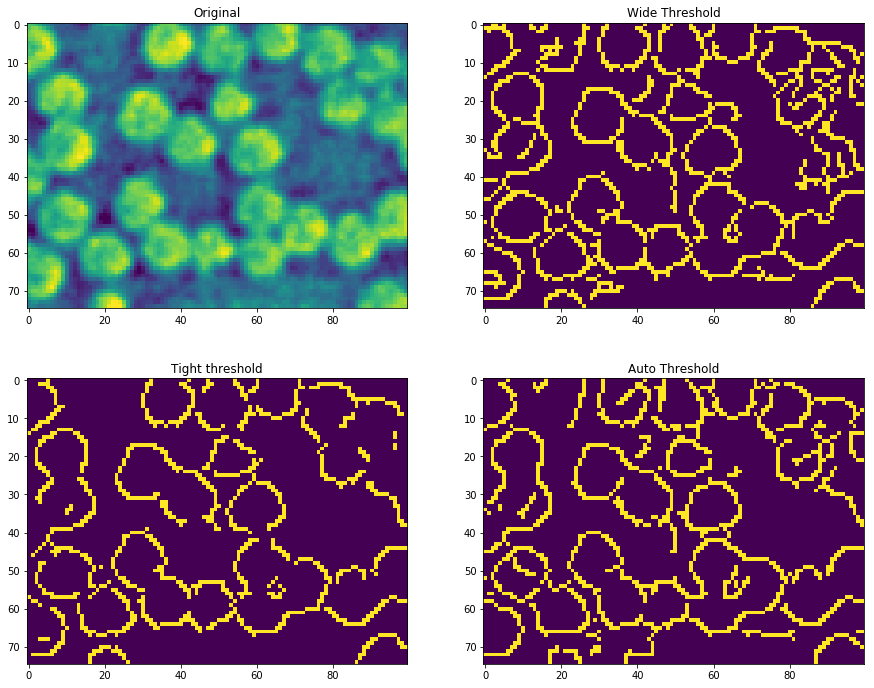

In [33]:
image_gray = ic[1000][600:800,600:800][75:150, 50:150]

gray = rgb2gray(image_gray)
blurred= 255-cv2.GaussianBlur(gray, (3, 3), 0)
 
# apply Canny edge detection using a wide threshold, tight
# threshold, and automatically determined threshold
wide = cv2.Canny(blurred, 10, 200)
tight = cv2.Canny(blurred, 225, 250)
auto = auto_canny(blurred)
 
# show the images
fig, ax = plt.subplots(2, 2, figsize=(15,12))
ax = ax.ravel()
ax[0].imshow(gray)
ax[0].set_title('Original')
ax[1].imshow(wide)
ax[1].set_title('Wide Threshold')
ax[2].imshow(tight)
ax[2].set_title('Tight threshold')
ax[3].imshow(auto)
ax[3].set_title('Auto Threshold')

#ax.imshow(image)
#ax
#cv2.imshow("Original", image)
#cv2.imshow("Edges", np.hstack([wide, tight, auto]))
#cv2.waitKey(0)

**SELECT YOUR PREFFERED METHOD TO PASS IN AS EDGES**

Which one?
1. 'Auto' (From canny detection)
2. 'Wide'
3. 'Tight'

**Iterating through radii for better hough transform performance**

In [34]:
rad_1 = np.arange(5,15,1)
rad_2 = np.arange(5, 25, 1)
all_opt = [(rad_1,'5-20-2'), (rad_2, '5-25-1')]


**Hough transform method using the edge detector above**

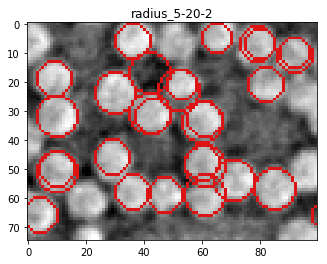

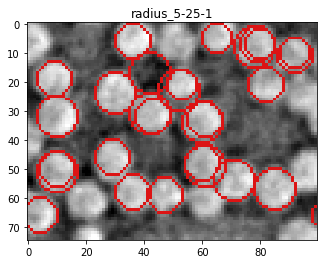

In [35]:
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

#image_gray = 255-median(image_gray, disk(2))

for (i,j) in all_opt:
    # SOME ENHANCING 
    #image_gray = median(image_gray, disk(2))
    #isodata == threshold
    
    # EDGES PRIOR TO HOUGH TRANSFORM 
    #edges = canny(image_gray, sigma=0.5, low_threshold=68, high_threshold=205) # these need to be calculated with func
    
    edges = auto

    # DETECT TWO RADII
    hough_radii = i  # what is your radius estimate?
    hough_res = hough_circle(edges, hough_radii)

    # SELECT THE MOST PROMINENT CIRCLES    
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                              total_num_peaks=28)
    
    # DRAW THEM
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,4))
    image = color.gray2rgb(image_gray)
    for center_y, center_x, radius in zip(cy,cx,radii):
        circy, circx = circle_perimeter(center_y, center_x, radius)
        image[circy, circx] = (220,20,20)


    ax.imshow(image, cmap=plt.cm.gray)
    ax.set_title('radius_' + j)
    #fig.savefig('hough_transform_radius/radius_icfiltered' + j +'.png')
    #plt.show()

# Watershed + Bilateral

In [36]:
import pandas as pd
from skimage import measure

# PATH FOR LOGGED
path_log = "/Users/mirasilvia/SULI Spring 2019/Summer 2019/Natalie's Data/recon/recon_20141209_235811_127_1_InSituPyro_curedRT_HC_7_enhcont/labeled/"


## Auxiliary Methods

**NOTE: HOW WILL WE KNOW WHICH PICTURE WE ARE TALKING ABOUT?**

In [37]:
# extracts info from logged file
def manually_counting(path_to_dir,num):
    fib_img = path_to_dir + 'FiberCenters' + num + '.tiff'
    crop_sample = io.imread(fib_img)
    
    df = pd.read_csv(path_to_dir+'FiberCenters'+ num +'.csv')
    count_fibs = len(df)
    
    return crop_sample, df, count_fibs
    

In [38]:
# techniques to enhance image in python prior to counting
def bilateral_watershed(picture):
    bilateral = restoration.denoise_bilateral(picture,multichannel=False) #review parameters
    thresh = threshold_isodata(bilateral)
    x = bilateral>thresh
    x =ndi.distance_transform_edt(x)
    #x = x>threshold_isodata(x)*1.75

    from skimage.segmentation import watershed
    #y = watershed(image_gray, x, watershed_line=True, compactness=)

    y = morphology.erosion(x, selem=morphology.disk(3))
    y = y>threshold_isodata(y)*1.75
    
    return x,y # before and after 

In [39]:
# counting in python 
def py_count(eroded_image):
    
    labels_white = measure.label(eroded_image)
    auto_count = labels_white.max()
    
    return auto_count, labels_white

In [40]:
def accuracy(auto_count, man_count):
    acc = (auto_count / man_count) * 100
    return acc

#### Props to:
http://www.icare.univ-lille1.fr/tutorials/convert_a_matplotlib_figure

https://stackoverflow.com/questions/21939658/matplotlib-render-into-buffer-access-pixel-data

In [41]:
# function to convert figure to an array
def fig2data (fig):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig, a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer: clears the fig 
    fig.canvas.draw()
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    print(w,h)
    buf = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
    buf.shape = (w,h,4 )
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll( buf, 3, axis = 2 )
    return buf

In [42]:
# https://stackoverflow.com/questions/31653576/how-to-calculate-the-mean-iu-score-in-image-segmentation
# https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal

from sklearn.metrics import confusion_matrix

def compute_iou(y_pred, y_true, file):
    
    measures = {}
    
    # y_pred, y_true are flattened vectors
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    
    current = confusion_matrix(y_true, y_pred, labels = [0,255])
    
    # compute mean iou
    intersection = np.diag(current)
    
    predicted_set = current.sum(axis=0)
    
    ground_truth_set = current.sum(axis=1)
    
    union = ground_truth_set + predicted_set - intersection
    
    IoU = intersection/union.astype(np.float32)
    
    # getting false positives/negatics and true positives/negatives
    #FP = predicted_set - intersection # cofusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
    #FN = ground_truth_set - intersection # confusion_matrix(axis=1 - np.diag(conf_matrix))
    #TP = intersection
    #TN = current.sum() - (FP + FN + TP)
    
    # binary case 
    FP = current[0,1]
    FN = current[1,0]
    TP = current[1,1]
    TN = current[0,0]
    
    # Sensitivity, hit rate, recall, or true positive rat
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    
    measures['File'] = file
    measures['Iou'] = np.mean(IoU)
    measures['Sensitivity (Recall)'] = TPR
    measures['Specificity (True Negative Rate)'] = TNR
    measures['Precision'] = PPV
    
    
    return measures

# ______________________________________________________________________

## Function Calls

In [61]:
# insert number of image cropped e.g. '1'
number = '0'

There is a total of 158 manually counted fibers
140 fibers automatically counted
Your accuracy is 88.60759493670885


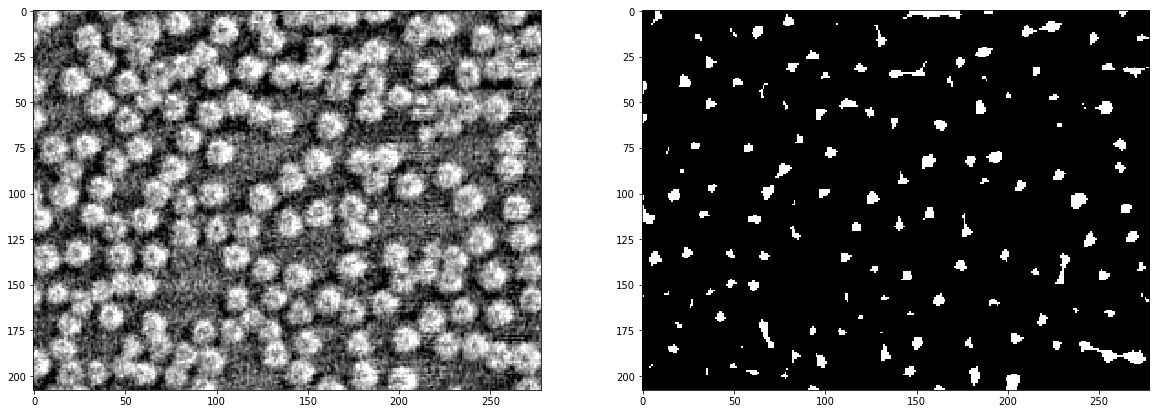

In [62]:
crop_pic, data_frame, manual_count = manually_counting(path_log, number)
# HOW MANY FIBERS? - obtained from length of dataframe
print('There is a total of '+ str(manual_count) + ' manually counted fibers')

# Image to apply techniques to is the cropped image: 'crop_pic'
a, b = bilateral_watershed(crop_pic)

# HOW MANY AUTOMATICALLY COUNTED fibers?
automated_count, labeled = py_count(b)
print(str(automated_count) + ' fibers automatically counted')

# WHAT'S THE ACCURACY?
print('Your accuracy is ' + str(accuracy(automated_count, manual_count)))

# HOW DO THESE IMAGES LOOK LIKE?
pltdani(crop_pic, b, 'gray')

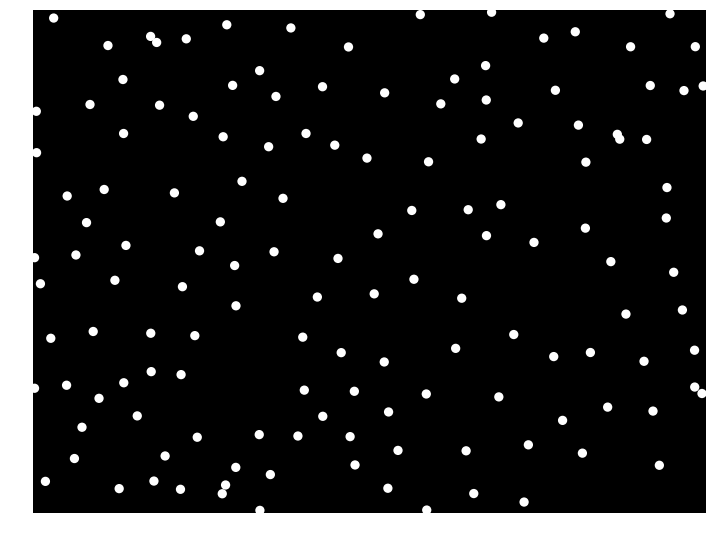

720 576


In [56]:
# create an empty black image of the same dimensions as "crop_pic"
black = np.zeros([crop_pic.shape[0], crop_pic.shape[1]], np.uint8)
figura, axial = plt.subplots(ncols=1,nrows=1, figsize=(10,8))
axial.imshow(black, cmap='gray')

for region in regionprops(labeled):
    #minr, minc, maxr, maxc = region.bbox
    #rect = mpatches.Rectangle((minc,minr), maxc-minc, maxr-minr,
    #                         fill=True, linewidth=2, color='white')
    
    row, col = region.centroid
    ellip = mpatches.Ellipse((col,row), 3, 3,
                            fill=True, linewidth=2, color='white')
    
    axial.add_patch(ellip)
axial.set_axis_off()
plt.tight_layout()
plt.show()
figura.savefig('test_bin_pool.png')
fig_as_array = fig2data(figura)
#plt.close(figura)


**RECALL THAT THE COORDINATES IN FIJI ARE FLIPPED WHEN COMPARING WITH PYTHON!)**

In [57]:
data_frame['X'] = [round(x) for x in data_frame['X']]
data_frame['Y'] = [round(y) for y in data_frame['Y']]
data_frame['coords'] = list(zip(data_frame.Y,data_frame.X))

In [58]:
black_px = black.copy()
for point in data_frame['coords']:
    black_px[point[0], point[1]] = 255

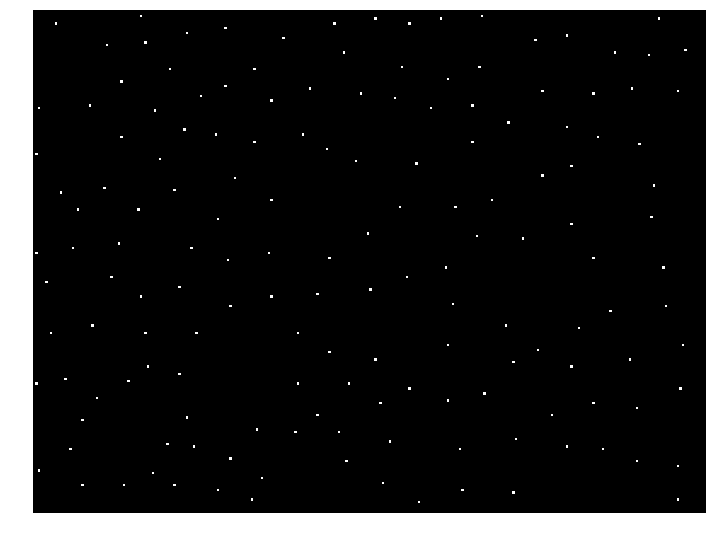

720 576


In [59]:
f3, ax3 = plt.subplots(1,1, figsize=(10,8))
ax3.imshow(black_px,cmap='gray')
ax3.set_axis_off()
plt.tight_layout()
plt.show()
f3.savefig('test_bin_pool2.png')
fig_arr_px = fig2data(f3)

In [60]:
# compute_iou(y_pred, y_true,file_name)
df_measures = compute_iou(fig_as_array, fig_arr_px,'none')
df_measures

{'File': 'none',
 'Iou': 0.9706783255169362,
 'Sensitivity (Recall)': 0.99584537128374,
 'Specificity (True Negative Rate)': 0.9814044971013467,
 'Precision': 0.9659871010801313}

# Test IoU

In [63]:
core = np.zeros((100, 100))
core[40:60,40:60] = 255

In [64]:
core2 = np.zeros((100, 100))
core2[50,50] = 255

In [65]:
test_iou = compute_iou(core, core2, 'none_test')

In [66]:
test_iou

{'File': 'none_test',
 'Iou': 0.48129800480048,
 'Sensitivity (Recall)': 1.0,
 'Specificity (True Negative Rate)': 0.9600960096009601,
 'Precision': 0.0025}

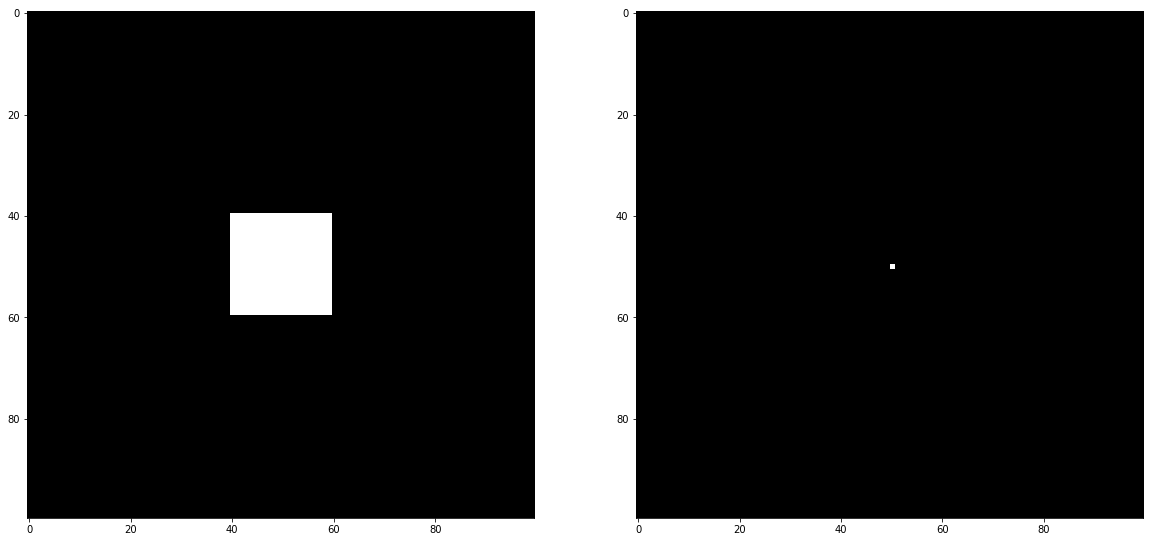

In [67]:
pltdani(core,core2,'gray')

# How does Dataset 3 behave with this algorithm?
Compare to its actual ground truth: in this case, we are doing slice 1000.

In [99]:
# read the images
rec_1000 = io.imread('rec_SFRR_2600_B0p2_01000.tiff')
gt_1000 = io.imread('19_Gray_1000.tif')

In [100]:
# are they the same shape?
rec_1000.shape == gt_1000.shape

True

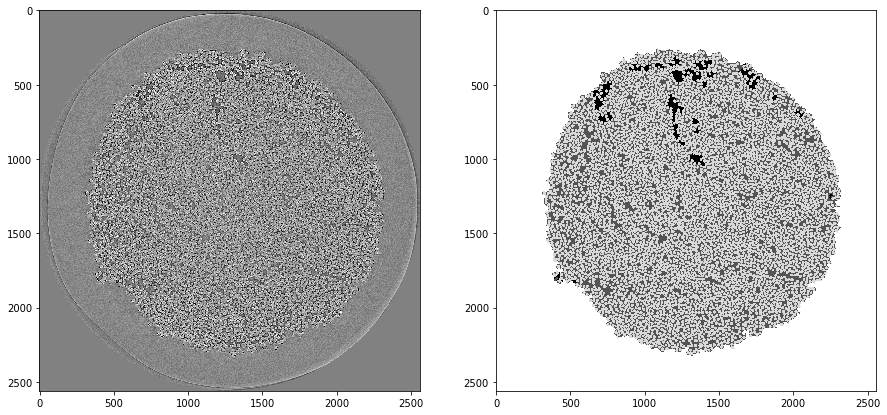

In [101]:
f_1000, ax_1000 = plt.subplots(1,2, figsize=(15,10))
ax_1000[0].imshow(rec_1000,cmap='gray')
ax_1000[1].imshow(gt_1000, cmap='gray')

In [102]:
crop_rec_1000 = rec_1000[1200:1300,1200:1300]
crop_gt_1000 = gt_1000[1200:1300,1200:1300]

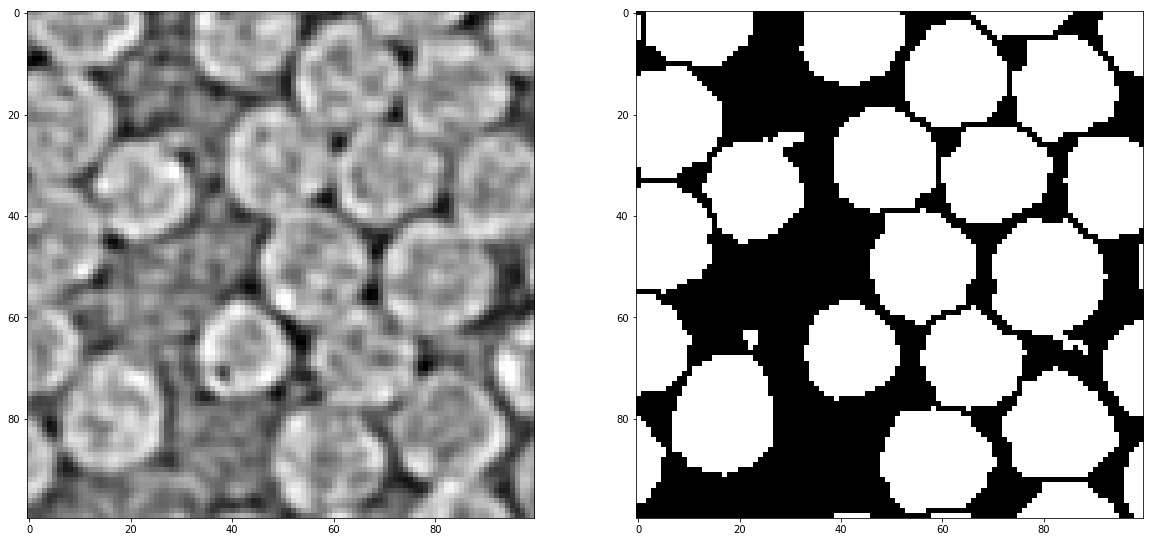

In [103]:
# did I lose some quality here?
pltdani(crop_rec_1000, crop_gt_1000,'gray')

12 fibers automatically counted
Your accuracy is 50.0


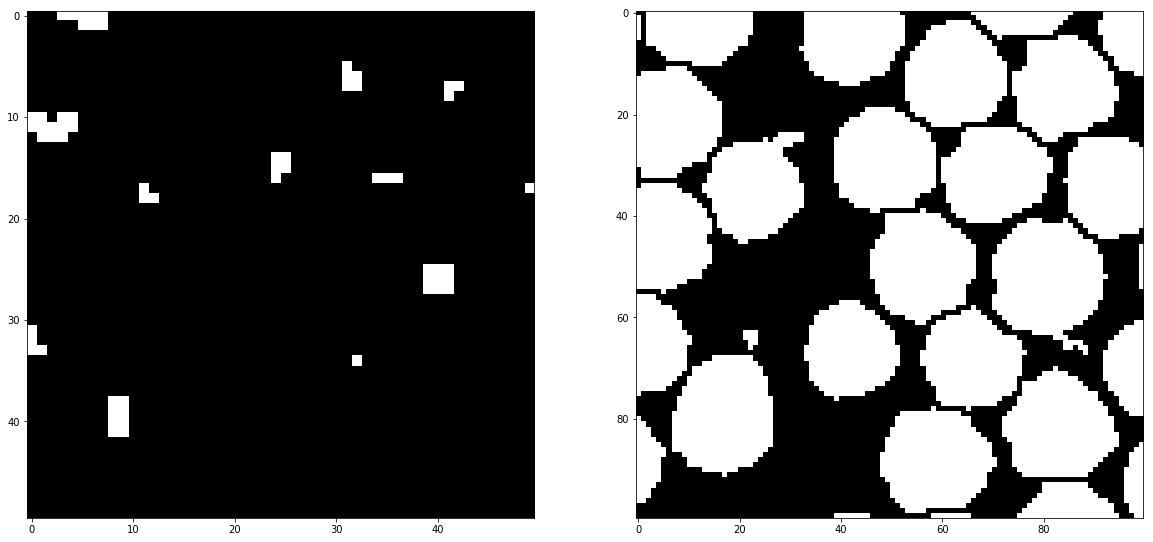

In [104]:
# RUN THE ALGORITHMS!

# apply algs to raw data: interesting result is the second var

crop_rec_1000 = crop_rec_1000[::2,::2]

d, s = bilateral_watershed(crop_rec_1000)

# how many did we get?
auto_count, labeled_crop = py_count(s)
print(str(auto_count) + ' fibers automatically counted')

hand_count = 24 # counted these by hand

# whats the accuracy?
print('Your accuracy is ' + str(accuracy(auto_count, hand_count)))

# how different do these two look?
pltdani(s, crop_gt_1000, 'gray')


In [89]:
another = py_count(crop_gt_1000)
another

(216, array([[  1,   1,   1, ...,  14,  14,  14],
        [  1,   1,   1, ...,  14,  14,  14],
        [  1,   1,   1, ...,  14,  14,  14],
        ...,
        [213, 213, 213, ..., 205, 205, 205],
        [213, 213, 213, ..., 205, 205, 205],
        [213, 213, 213, ...,   2, 205, 205]]))

In [ ]:
# Image to apply techniques to is the cropped image: 'crop_pic'
a, b = bilateral_watershed(crop_pic)

# HOW MANY AUTOMATICALLY COUNTED fibers?
automated_count, labeled = py_count(b)
print(str(automated_count) + ' fibers automatically counted')

# WHAT'S THE ACCURACY?
print('Your accuracy is ' + str(accuracy(automated_count, manual_count)))

# HOW DO THESE IMAGES LOOK LIKE?
pltdani(crop_pic, b, 'gray')

# Other ways to detect circles
Not succeeded (yet).

In [ ]:
#See how local maxima fails miserably
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

im = img_as_float(img)

# image_max is the dilation of im with a 20*20 structuring element
# It is used within peak_local_max function
image_max = ndi.maximum_filter(im, footprint=disk(30), mode='constant')

# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(im, min_distance=20)

# display results
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(im, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(image_max, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Maximum filter')

ax[2].imshow(im, cmap=plt.cm.gray)
ax[2].autoscale(False)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[2].axis('off')
ax[2].set_title('Peak local max')

fig.tight_layout()

plt.show()

In [ ]:
#failed too
from skimage.morphology import watershed
distance = ndi.distance_transform_edt(img)
local_maxi = peak_local_max(distance, indices=False, footprint=disk(3),
                            labels=img)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=img)

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

hello
